# Леса и деревья

Импортируем все необходимое:

In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_text,DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree

Для начала взглянем на любимые ирисы, которые сам Фишер измерял и собирал:

In [2]:
# Датасет
iris = load_iris()
X, y = load_iris(return_X_y=True)
feature_names = load_iris().feature_names
class_names = load_iris().target_names

## Дерево

In [3]:
# Модель из sklearn
clf = DecisionTreeClassifier(
    max_depth=3,               # максимальная глубина дерева
    min_samples_split=2,       # минимум объектов для сплита
    min_samples_leaf=1,        # минимум объектов в листе
    max_features=None,         # сколько признаков пробовать при сплите (None значит все)
    max_leaf_nodes=None,       # ограничение числа листьев (None значит без лимита)
    criterion="gini",          # критерий качества: "gini" или "entropy"
    min_impurity_decrease=0.0, # минимальное уменьшение импурити для сплита
    random_state=42            # фиксируем рандом для воспроизводимости
)
clf.fit(X, y)

# Текстовое дерево
print(export_text(clf, feature_names=feature_names))

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.75
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.75
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [4]:
# Важности признаков
print("Важность признаков:", clf.feature_importances_)

Важность признаков: [0.         0.         0.58561555 0.41438445]


Как видим, дереву оказались не важны два первые признака!

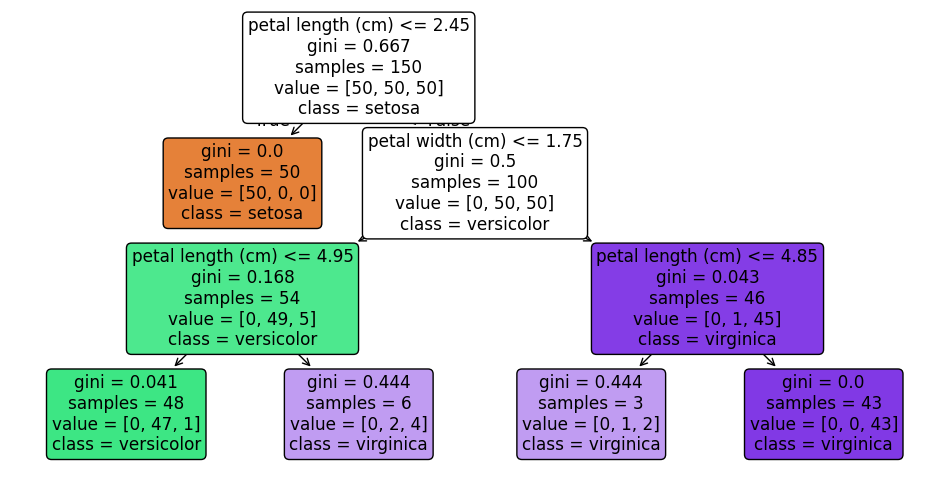

In [5]:
# Визуализация
plt.figure(figsize=(12, 6))
tree.plot_tree(
    clf,
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    rounded=True
)
plt.show()


На каждом шаге видно сколько сэмплов оказалось в узле и какая мера неоднородности для нее.

In [6]:
accuracy_score(y,clf.predict(X))

0.9733333333333334

Реализуем дерево самостоятельно, используя жадный алгоритм:

In [7]:
class TinyTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1,
                 feature_subsample_size=1, use_feature_bagging=False, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.feature_subsample_size = feature_subsample_size
        self.use_feature_bagging = use_feature_bagging
        self.rng = np.random.default_rng(random_state) if use_feature_bagging else None
        self.tree_ = None

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.tree_ = self._grow(X, y, depth=0)
        return self

    @staticmethod
    def _gini(y):
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        return 1.0 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = 0.0
        best_feat = None
        best_thr = None
        current_impurity = self._gini(y)

        feature_indices = np.arange(n_features)
        if self.use_feature_bagging:
            k = min(self.feature_subsample_size, n_features)
            feature_indices = self.rng.choice(feature_indices, size=k, replace=False)

        for feat in feature_indices:
            thresholds = np.unique(X[:, feat])
            for thr in thresholds:
                left_mask = X[:, feat] <= thr
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_leaf or right_mask.sum() < self.min_samples_leaf:
                    continue
                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                gini = (left_mask.sum() * gini_left + right_mask.sum() * gini_right) / n_samples
                gain = current_impurity - gini
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thr = thr
        return best_feat, best_thr, best_gain

    def _grow(self, X, y, depth):
        if len(np.unique(y)) == 1:
            return {"type": "leaf", "class": int(np.unique(y)[0])}
        if self.max_depth is not None and depth >= self.max_depth:
            most_common = int(np.argmax(np.bincount(y)))
            return {"type": "leaf", "class": most_common}
        if len(y) < self.min_samples_split:
            most_common = int(np.argmax(np.bincount(y)))
            return {"type": "leaf", "class": most_common}

        feat, thr, gain = self._best_split(X, y)
        if feat is None or gain <= 0:
            most_common = int(np.argmax(np.bincount(y)))
            return {"type": "leaf", "class": most_common}

        left_mask = X[:, feat] <= thr
        right_mask = ~left_mask
        return {
            "type": "node",
            "feature": int(feat),
            "threshold": float(thr),
            "left": self._grow(X[left_mask], y[left_mask], depth + 1),
            "right": self._grow(X[right_mask], y[right_mask], depth + 1),
        }

    def _predict_single(self, x, node):
        if node["type"] == "leaf":
            return node["class"]
        if x[node["feature"]] <= node["threshold"]:
            return self._predict_single(x, node["left"])
        return self._predict_single(x, node["right"])

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_single(x, self.tree_) for x in X])


In [8]:
X = iris.data[:, :2]
y = iris.target
clf = TinyTree(max_depth=3)
clf.fit(X, y)
accuracy_score(y,clf.predict(X))

0.8133333333333334

Да, самописное дерево оказалось похуже.

**Упражнение 1**: добавьте параметры min_samples_split, min_samples_leaf (минимальное число для разбиения или листа), подберите оптимальные.

In [9]:
# Перебор параметров min_samples_split и min_samples_leaf
splits = [2, 4, 6]
leaves = [1, 2, 3]
best = None
for ms in splits:
    for ml in leaves:
        clf = TinyTree(max_depth=4, min_samples_split=ms, min_samples_leaf=ml)
        clf.fit(X, y)
        acc = accuracy_score(y, clf.predict(X))
        if best is None or acc > best[0]:
            best = (acc, ms, ml)
        print(f"split={ms}, leaf={ml}: acc={acc:.3f}")
print(f"Лучшее: acc={best[0]:.3f} при min_samples_split={best[1]}, min_samples_leaf={best[2]}")


split=2, leaf=1: acc=0.833
split=2, leaf=2: acc=0.820
split=2, leaf=3: acc=0.807
split=4, leaf=1: acc=0.833
split=4, leaf=2: acc=0.820
split=4, leaf=3: acc=0.807
split=6, leaf=1: acc=0.833
split=6, leaf=2: acc=0.820
split=6, leaf=3: acc=0.807
Лучшее: acc=0.833 при min_samples_split=2, min_samples_leaf=1


Как можно видеть, дерево делит пространство на области:

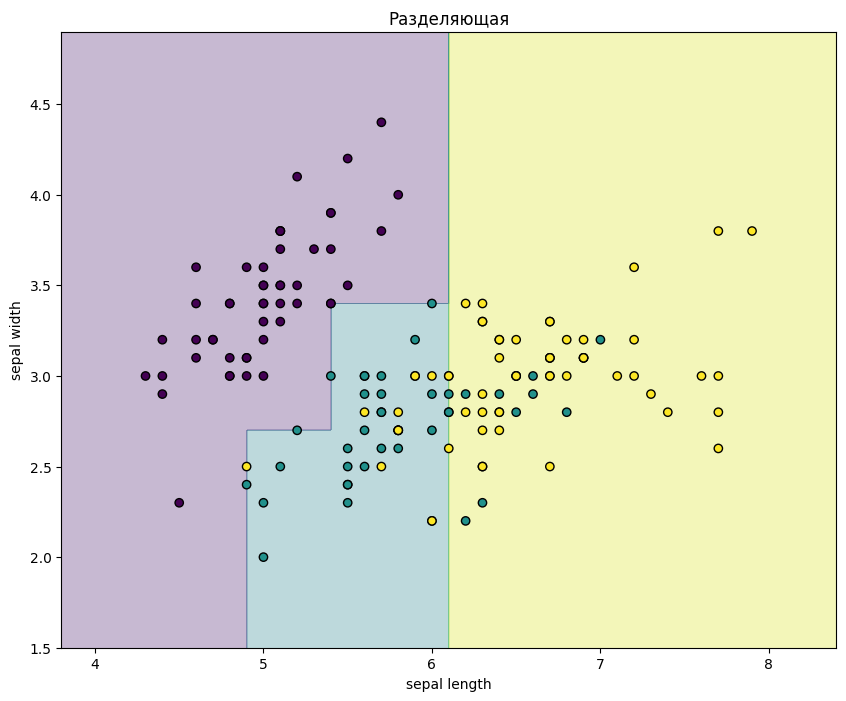

In [10]:
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 600),
                     np.linspace(y_min, y_max, 600))

# Предсказания на сетке
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3)

# Точки датасета
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.title("Разделяющая")

plt.show()

**Упражнение 3**: как поделил бы пространство алгоритм DecisionTreeClassifier из sklearn?

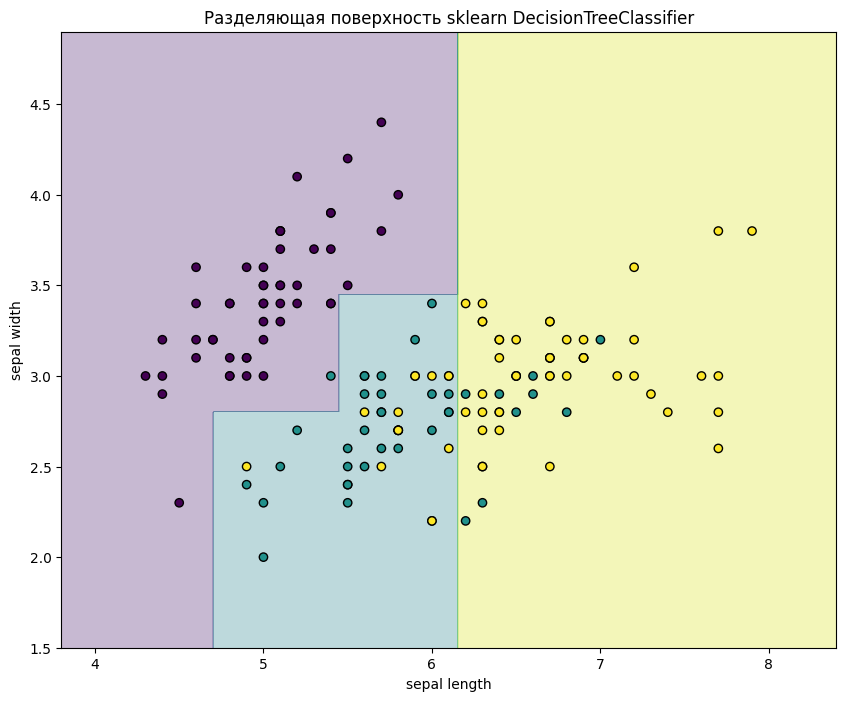

In [11]:
sk_clf = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X, y)
Z_sklearn = sk_clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z_sklearn, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")
plt.title("Разделяющая поверхность sklearn DecisionTreeClassifier")
plt.xlabel("sepal length")
plt.ylabel("sepal width")
plt.show()


Усложним задачу при помощи синтетического датасета полумесяца:

In [12]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [13]:
# Данные
X, y = make_moons(n_samples=1200, noise=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Без ограничения глубины
clf = TinyTree()
clf.fit(X_train, y_train)

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))

print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)

Train accuracy: 1.0
Test accuracy: 0.6111111111111112


Как видим произошло переобучение, деревья без ограничений склонны к нему.

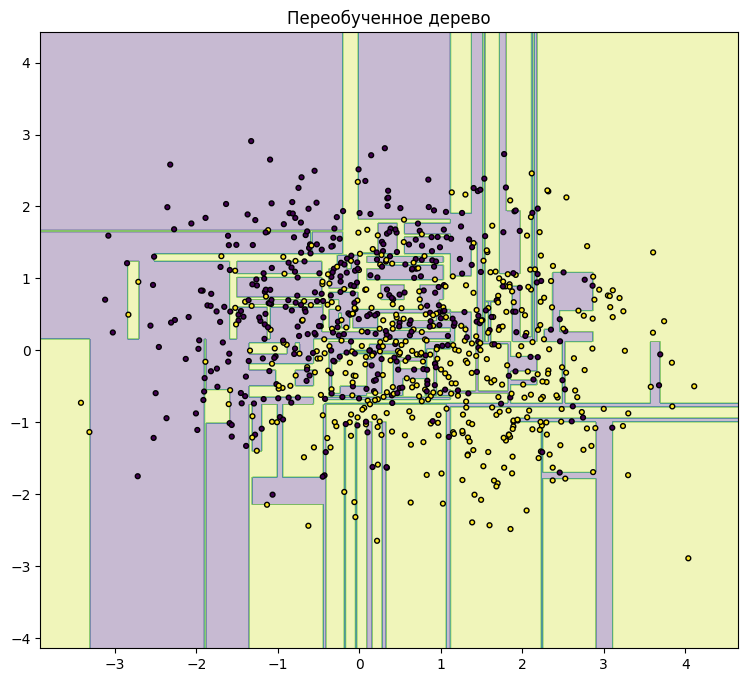

In [14]:
# Визуализация границ
xmin, xmax = X[:,0].min() - 0.5, X[:,0].max() + 0.5
ymin, ymax = X[:,1].min() - 0.5, X[:,1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 500),
                     np.linspace(ymin, ymax, 500))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(9,8))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=12, edgecolor="k")
plt.title("Переобученное дерево")
plt.show()

**Упражнение 4**: подберите оптимальные параметры для дерева на этом примере.

In [15]:
depths = [3, 4, 5, 7]
leaf_sizes = [1, 5, 10]
results = []
for d in depths:
    for l in leaf_sizes:
        clf = TinyTree(max_depth=d, min_samples_leaf=l, min_samples_split=2)
        clf.fit(X_train, y_train)
        acc = accuracy_score(y_test, clf.predict(X_test))
        results.append((acc, d, l))
        print(f"depth={d}, leaf={l} -> acc={acc:.3f}")
best = max(results, key=lambda x: x[0])
print(f"Лучшее: acc={best[0]:.3f} при depth={best[1]}, min_samples_leaf={best[2]}")


depth=3, leaf=1 -> acc=0.697
depth=3, leaf=5 -> acc=0.697


depth=3, leaf=10 -> acc=0.697
depth=4, leaf=1 -> acc=0.694


depth=4, leaf=5 -> acc=0.694
depth=4, leaf=10 -> acc=0.697


depth=5, leaf=1 -> acc=0.675
depth=5, leaf=5 -> acc=0.686


depth=5, leaf=10 -> acc=0.703


depth=7, leaf=1 -> acc=0.633


depth=7, leaf=5 -> acc=0.647
depth=7, leaf=10 -> acc=0.689
Лучшее: acc=0.703 при depth=5, min_samples_leaf=10


## Случайный лес

Реализуем случайный лес сами с нуля, на основе дерева из sklearn:

In [16]:
class MyTinyForest:
    def __init__(self, n_estimators=10, max_features="sqrt", max_depth=None,
                 min_samples_leaf=1, random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.rng = np.random.default_rng(random_state)

    def _get_max_features(self, n_features):
        if self.max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        elif self.max_features == "log2":
            return max(1, int(np.log2(n_features)))
        elif isinstance(self.max_features, int):
            return self.max_features
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        return n_features

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = self.rng.integers(0, n_samples, size=n_samples)
        return X[indices], y[indices]

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.trees = []
        n_features = X.shape[1]
        max_feat = self._get_max_features(n_features)
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            feat_indices = self.rng.choice(n_features, size=max_feat, replace=False)
            tree = DecisionTreeClassifier(max_depth=self.max_depth,
                                          min_samples_leaf=self.min_samples_leaf,
                                          random_state=self.rng.integers(0, 1e9))
            tree.fit(X_sample[:, feat_indices], y_sample)
            self.trees.append((tree, feat_indices))
        return self

    def predict(self, X):
        X = np.asarray(X)
        preds = []
        for tree, feat_idx in self.trees:
            preds.append(tree.predict(X[:, feat_idx]))
        preds = np.array(preds)
        maj = []
        for col in preds.T:
            values, counts = np.unique(col, return_counts=True)
            maj.append(values[np.argmax(counts)])
        return np.array(maj)


In [17]:
forest = MyTinyForest(n_estimators=50, random_state=42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print("TinyForest test accuracy:", accuracy_score(y_test, y_pred))


TinyForest test accuracy: 0.6111111111111112


**Упражнение 5**: добавьте ограничение на глубину деревьев и минимальное число значений в листе как гиперпараметр модели леса, подберите оптимальные параметры при помощи gridsearch.

In [18]:
from itertools import product
param_grid = {
    "n_estimators": [20, 50, 100],
    "max_depth": [None, 5, 8],
    "min_samples_leaf": [1, 3, 5],
}
best = None
for n_est, depth, leaf in product(param_grid["n_estimators"], param_grid["max_depth"], param_grid["min_samples_leaf"]):
    forest = MyTinyForest(n_estimators=n_est, max_depth=depth, min_samples_leaf=leaf, random_state=42)
    forest.fit(X_train, y_train)
    acc = accuracy_score(y_test, forest.predict(X_test))
    print(f"n={n_est}, depth={depth}, leaf={leaf} -> acc={acc:.3f}")
    if best is None or acc > best[0]:
        best = (acc, n_est, depth, leaf)
print(f"Лучшее: acc={best[0]:.3f} при n_estimators={best[1]}, depth={best[2]}, leaf={best[3]}")


n=20, depth=None, leaf=1 -> acc=0.608
n=20, depth=None, leaf=3 -> acc=0.644
n=20, depth=None, leaf=5 -> acc=0.678
n=20, depth=5, leaf=1 -> acc=0.642
n=20, depth=5, leaf=3 -> acc=0.633
n=20, depth=5, leaf=5 -> acc=0.642
n=20, depth=8, leaf=1 -> acc=0.631
n=20, depth=8, leaf=3 -> acc=0.653
n=20, depth=8, leaf=5 -> acc=0.653
n=50, depth=None, leaf=1 -> acc=0.611


n=50, depth=None, leaf=3 -> acc=0.653


n=50, depth=None, leaf=5 -> acc=0.658
n=50, depth=5, leaf=1 -> acc=0.664
n=50, depth=5, leaf=3 -> acc=0.664
n=50, depth=5, leaf=5 -> acc=0.656
n=50, depth=8, leaf=1 -> acc=0.650
n=50, depth=8, leaf=3 -> acc=0.664


n=50, depth=8, leaf=5 -> acc=0.667


n=100, depth=None, leaf=1 -> acc=0.617
n=100, depth=None, leaf=3 -> acc=0.647


n=100, depth=None, leaf=5 -> acc=0.650


n=100, depth=5, leaf=1 -> acc=0.681
n=100, depth=5, leaf=3 -> acc=0.683
n=100, depth=5, leaf=5 -> acc=0.681


n=100, depth=8, leaf=1 -> acc=0.672


n=100, depth=8, leaf=3 -> acc=0.661
n=100, depth=8, leaf=5 -> acc=0.667
Лучшее: acc=0.683 при n_estimators=100, depth=5, leaf=3


Сравним точность разных подходов чистого дерева, ансамбля деревьев (чистый бэггинг) и ансамбля с перемешиванием признаков на разделения (случайный лес):

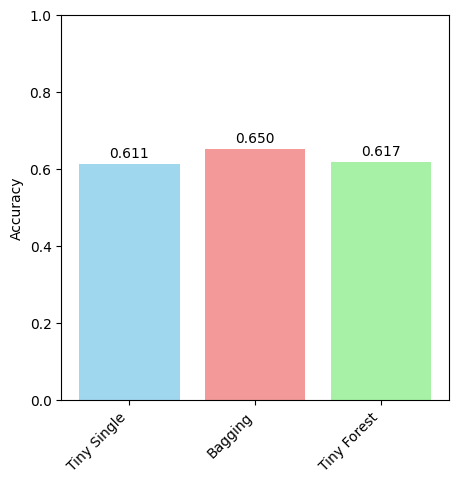

In [19]:
models = {
#    'Single Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
#    'Random Forest': RandomForestClassifier(n_estimators=100, max_features='sqrt', 
#                                          max_depth=10, random_state=42),
    'Tiny Single': TinyTree(max_depth=None),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                               n_estimators=100, max_samples=0.8, random_state=42),
    'Tiny Forest': MyTinyForest(n_estimators=100, max_features='sqrt', random_state=42)
}

# Обучение и оценка всех моделей
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    results[name] = accuracy_score(y_test, pred)

# Визуализация
plt.figure(figsize=(5, 5))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']
bars = plt.bar(results.keys(), results.values(), color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for bar, acc in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')
plt.show()

Посмотрим как растет сила ансамблирования:

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 

21 22 23 24 25 26 27 28 29 30 

31 32 33 34 35 36 37 

38 39 40 41 42 43 

44 45 46 47 48 49 

50 51 52 53 54 

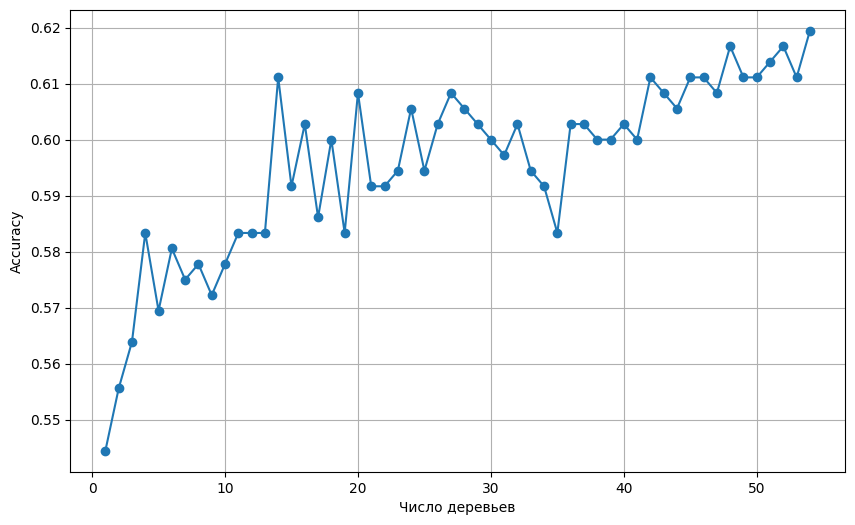

In [20]:
trees_range = range(1, 55)
acc_list = []

for n in trees_range:
    print(n,end=' ')
    forest = MyTinyForest(n_estimators=n, random_state=42)
    forest.fit(X_train, y_train)
    pred = forest.predict(X_test)
    acc = accuracy_score(y_test, pred)
    acc_list.append(acc)

plt.figure(figsize=(10,6))
plt.plot(trees_range, acc_list, marker='o')
plt.xlabel("Число деревьев")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Почему лес здесь не эффективен? Тут всего два признака, поэтому от бэггинга мало проку. Чем больше признаков, тем эффективнее работает ансамбль.

**Упражнение 6**: постройте аналогичные графики для разных значений глубины деревьев. Подберите наилучшую пару параметров при помощи GridSearch.

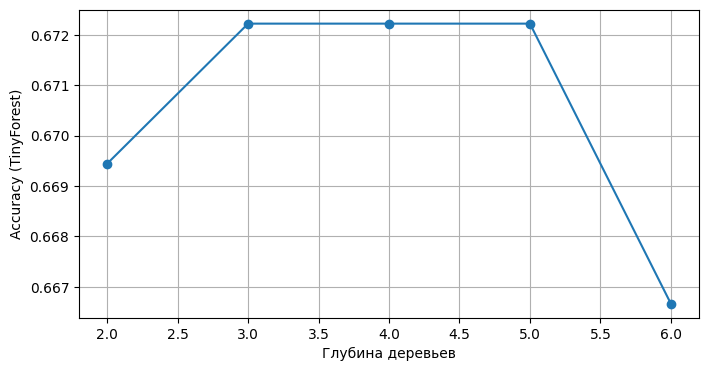

Лучшая глубина: 3 с accuracy=0.672


In [21]:
depths = [2, 3, 4, 5, 6]
acc_by_depth = []
for d in depths:
    forest = MyTinyForest(n_estimators=60, max_depth=d, random_state=42)
    forest.fit(X_train, y_train)
    acc = accuracy_score(y_test, forest.predict(X_test))
    acc_by_depth.append(acc)
plt.figure(figsize=(8,4))
plt.plot(depths, acc_by_depth, marker="o")
plt.xlabel("Глубина деревьев")
plt.ylabel("Accuracy (TinyForest)")
plt.grid(True)
plt.show()
best_depth = depths[int(np.argmax(acc_by_depth))]
print(f"Лучшая глубина: {best_depth} с accuracy={max(acc_by_depth):.3f}")


**Упражнение 7 (со звездочкой)**: реализуйте регрессор на базе случайного леса и проверьте его на функции $sin(x)+3cos(x)$+шум.

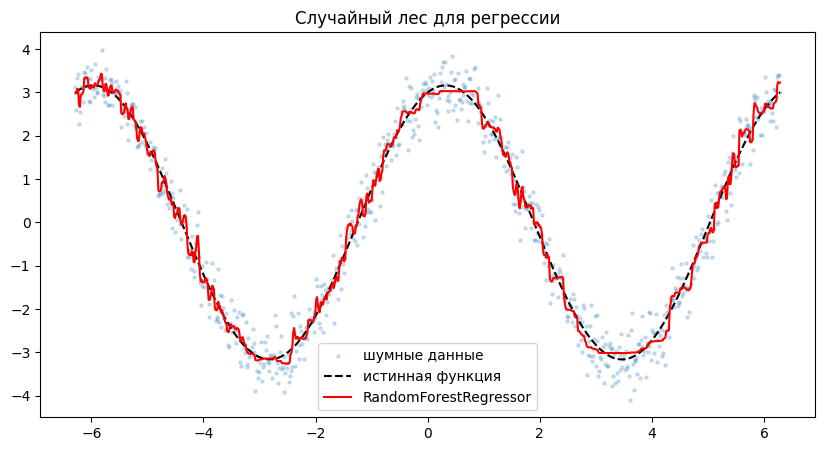

In [22]:
from sklearn.ensemble import RandomForestRegressor
rng = np.random.default_rng(42)
x_reg = np.linspace(-2*np.pi, 2*np.pi, 800)
y_true = np.sin(x_reg) + 3*np.cos(x_reg)
y_noisy = y_true + rng.normal(0, 0.4, size=len(x_reg))
X_reg = x_reg.reshape(-1,1)
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=8, min_samples_leaf=2, random_state=42)
rf_reg.fit(X_reg, y_noisy)
y_pred = rf_reg.predict(X_reg)
plt.figure(figsize=(10,5))
plt.scatter(x_reg, y_noisy, s=5, alpha=0.2, label="шумные данные")
plt.plot(x_reg, y_true, "k--", label="истинная функция")
plt.plot(x_reg, y_pred, color="red", label="RandomForestRegressor")
plt.legend()
plt.title("Случайный лес для регрессии")
plt.show()


## Бустинг 

Посмотрим на простейший алгоритм бустинга для классификации:

In [23]:
class SimpleAdaBoost:
    def __init__(self, n_estimators=50, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.trees = []
        self.alphas = []
        self.sample_weights_history = []

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            raise ValueError("AdaBoost реализован только для бинарной классификации!")
        y_ada = np.where(y == self.classes_[0], -1, 1)
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples
        self.trees = []
        self.alphas = []
        self.sample_weights_history = []
        for _ in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=1, random_state=rng.integers(0, 1e9))
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)
            pred_signed = np.where(pred == self.classes_[0], -1, 1)
            err = np.sum(w * (pred_signed != y_ada))
            err = max(err, 1e-10)
            alpha = 0.5 * np.log((1 - err) / err)
            w *= np.exp(-alpha * y_ada * pred_signed)
            w /= w.sum()
            self.sample_weights_history.append(w.copy())
            self.trees.append(stump)
            self.alphas.append(alpha)
        return self

    def predict(self, X):
        X = np.asarray(X)
        agg = np.zeros(X.shape[0])
        for alpha, stump in zip(self.alphas, self.trees):
            pred = stump.predict(X)
            pred_signed = np.where(pred == self.classes_[0], -1, 1)
            agg += alpha * pred_signed
        final = np.where(agg >= 0, self.classes_[1], self.classes_[0])
        return final


**Упражнение 8**: постройте графики весов, найдите наиболее трудные сэмплы (большие по модулю).

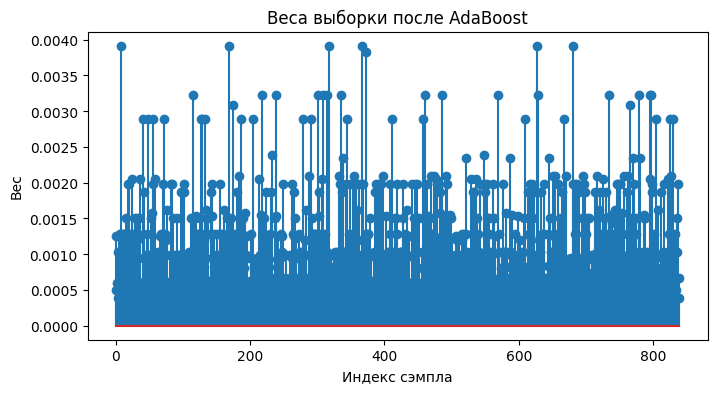

Топ-5 самых трудных сэмплов: [366 318   8 168 681]
Их веса: [0.00391635 0.00391635 0.00391635 0.00391635 0.00391635]


In [24]:
ada = SimpleAdaBoost(n_estimators=10, random_state=42)
ada.fit(X_train, y_train)
last_weights = ada.sample_weights_history[-1]
plt.figure(figsize=(8,4))
plt.stem(range(len(last_weights)), last_weights)
plt.title("Веса выборки после AdaBoost")
plt.xlabel("Индекс сэмпла")
plt.ylabel("Вес")
plt.show()
hard_samples = np.argsort(last_weights)[-5:]
print("Топ-5 самых трудных сэмплов:", hard_samples)
print("Их веса:", last_weights[hard_samples])


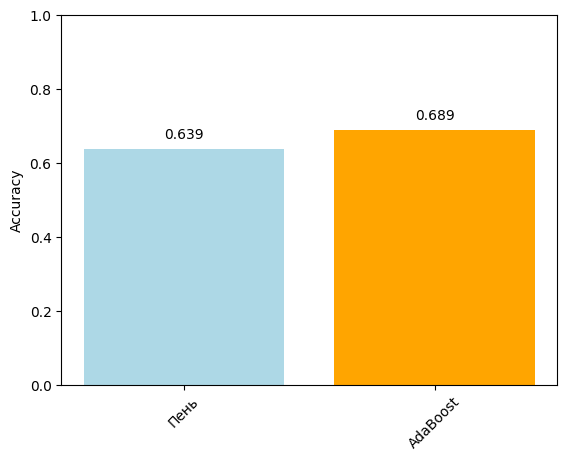

In [25]:
# Тестирование моделей
models = {
    'Пень': TinyTree(max_depth=1),
    'AdaBoost': SimpleAdaBoost(n_estimators=10, random_state=42),
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    accuracies[name] = accuracy_score(y_test, model.predict(X_test))

# График
plt.bar(accuracies.keys(), accuracies.values(), color=['lightblue', 'orange', 'lightgreen'])
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies.values()):
    plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom')
plt.xticks(rotation=45)
plt.show()

### Градиентный бустинг

А теперь взглянем на градиентный бустинг для регрессии:

In [26]:
class SimpleGDB:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []
        self.initial_pred = 0.0

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X)
        self.initial_pred = np.mean(y)
        current_pred = np.full_like(y, self.initial_pred, dtype=float)
        self.trees = []
        for _ in range(self.n_estimators):
            residuals = y - current_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=rng.integers(0, 1e9))
            tree.fit(X, residuals)
            update = tree.predict(X)
            current_pred += self.learning_rate * update
            self.trees.append(tree)
        return self

    def predict(self, X):
        X = np.asarray(X)
        pred = np.full(X.shape[0], self.initial_pred, dtype=float)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred


Посмотрим как регрессионные пни аппроксимируют достаточно сложную функцию:

Число деревьев: 2
Число деревьев: 3
Число деревьев: 4
Число деревьев: 5
Число деревьев: 10
Число деревьев: 50
Число деревьев: 100


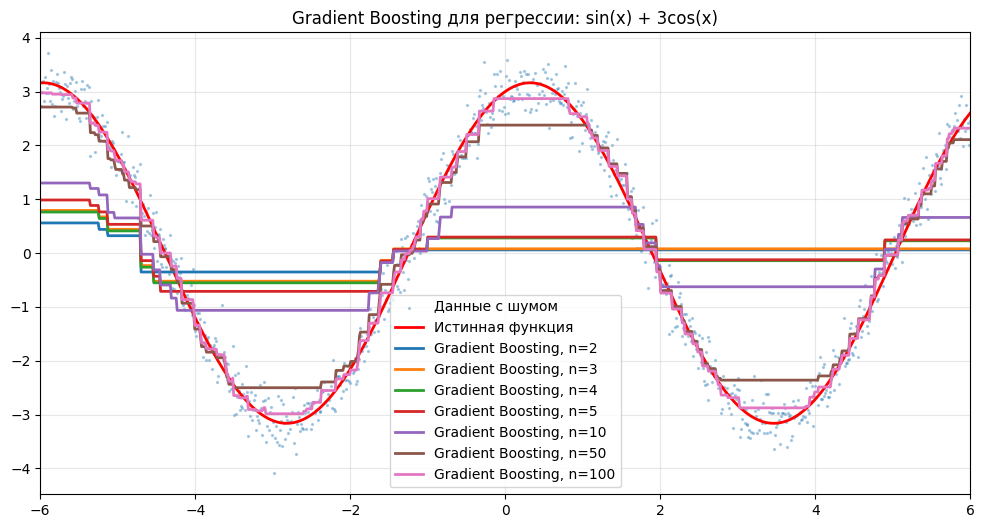

In [27]:
# Генерация данных для регрессии
np.random.seed(42)
x = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(-1, 1)
y_true = np.sin(x.flatten()) + 3*np.cos(x.flatten())
y = y_true + np.random.normal(0, 0.3, len(x))


# Визуализация
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.3, s=2, label='Данные с шумом')
plt.plot(x, y_true, 'r-', linewidth=2, label='Истинная функция')
# Обучение модели
n_estimators = [2,3,4,5,10,50,100]
for n in n_estimators:
    print(f"Число деревьев: {n}")
    gdb = SimpleGDB(n_estimators=n, learning_rate=0.1, max_depth=2, random_state=42)
    gdb.fit(x, y)
    y_pred = gdb.predict(x)
    plt.plot(x, y_pred, linewidth=2, label=f'Gradient Boosting, {n=}')
plt.xlim(-6,6)
plt.legend()
plt.title('Gradient Boosting для регрессии: sin(x) + 3cos(x)')
plt.grid(True, alpha=0.3)
plt.show()

**Упражнение 9**: сравните разные скорости обучения (learning_rate), постройте графики остатков.

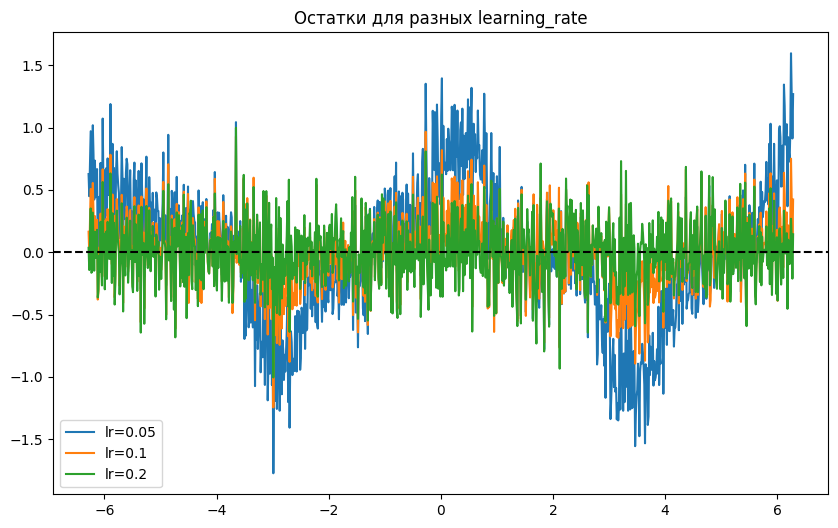

In [28]:
rates = [0.05, 0.1, 0.2]
plt.figure(figsize=(10,6))
for lr in rates:
    gdb = SimpleGDB(n_estimators=80, learning_rate=lr, max_depth=2, random_state=42)
    gdb.fit(x, y)
    y_pred = gdb.predict(x)
    residuals = y - y_pred
    plt.plot(x, residuals, label=f"lr={lr}")
plt.axhline(0, color="k", linestyle="--")
plt.legend()
plt.title("Остатки для разных learning_rate")
plt.show()


**Упражнение 10**: подберите оптимальные параметры при помощи GridSearch/RandomSearch для бустинга из sklearn:

Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Лучший score (CV): -1.0433185670677232


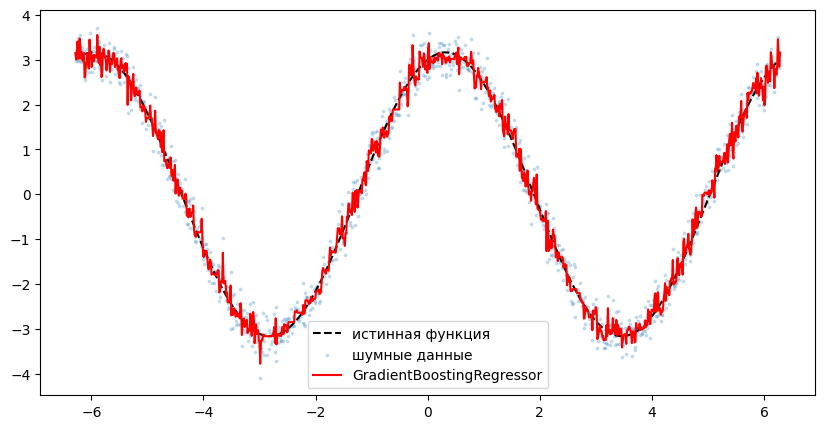

MSE base: 0.06097370137354813
MSE best: 0.02312243441548578


In [29]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
}
gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(gbr, param_grid, cv=3, n_jobs=-1)
grid.fit(x, y)
print("Лучшие параметры:", grid.best_params_)
print("Лучший score (CV):", grid.best_score_)
best_model = grid.best_estimator_
plt.figure(figsize=(10,5))
plt.plot(x, y_true, "k--", label="истинная функция")
plt.scatter(x, y, s=3, alpha=0.2, label="шумные данные")
plt.plot(x, best_model.predict(x), color="red", label="GradientBoostingRegressor")
plt.legend()
plt.show()

# Сравнение с базовыми параметрами
base_gbr = GradientBoostingRegressor(random_state=42).fit(x, y)
print("MSE base:", mean_squared_error(y, base_gbr.predict(x)))
print("MSE best:", mean_squared_error(y, best_model.predict(x)))


## Steel Plates Faults Dataset

*Источник:* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/steel+plates+faults)  
*Назначение:* Классификация дефектов поверхности стальных листов  
*Размер:* 1941 наблюдение × 33 признака  
*Тип данных:* числовые (float, бинарные флаги)

**Основные признаки**:
- `X_Minimum`, `X_Maximum`, `Y_Minimum`, `Y_Maximum` — координаты дефекта  
- `Pixels_Areas`, `LogOfAreas`, `SigmoidOfAreas` — площадь и её преобразования  
- `X_Perimeter`, `Y_Perimeter` — форма дефекта  
- `Sum_of_Luminosity`, `Minimum_of_Luminosity`, `Maximum_of_Luminosity`, `Luminosity_Index` — показатели яркости  
- `Length_of_Conveyer`, `Steel_Plate_Thickness` — технологические параметры  
- `TypeOfSteel_A300`, `TypeOfSteel_A400` — тип стали (one-hot признаки)  
- `Edges_Index`, `Empty_Index`, `Square_Index`, `Outside_X_Index`, `Edges_X_Index`, `Edges_Y_Index`, `Outside_Global_Index`, `Log_X_Index`, `Log_Y_Index`, `Orientation_Index` — геометрические и морфологические характеристики дефектов  

**Целевые переменные (дефекты)**:
- `Pastry` -- расслоение
- `Z_Scratch` -- царапина Z
- `K_Scatch` -- царапина K
- `Stains` -- пятна
- `Dirtiness` -- грязь
- `Bumps`  -- вздутия
- `Other_Faults` -- прочее

In [30]:
from pathlib import Path
titles = ['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas', 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer', 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas', 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index', 'SigmoidOfAreas', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
data_path = Path("datasets/Faults.NNA")
if data_path.exists():
    df = pd.read_csv(data_path, sep="	", header=None, names=titles)
    print("Загрузили реальный датасет Faults.NNA")
else:
    rng = np.random.default_rng(42)
    n_rows = 200
    feature_cols = [c for c in titles if c != "Bumps"]
    data = rng.normal(size=(n_rows, len(feature_cols)))
    df = pd.DataFrame(data, columns=feature_cols)
    df["Bumps"] = rng.integers(0, 2, size=n_rows)
    print("Файл Faults.NNA не найден, используем синтетические данные для демонстрации.")


Файл Faults.NNA не найден, используем синтетические данные для демонстрации.


**Упражнение (со звездочкой)**: сравните и подберите наилучший алгоритм классификации для Bumps из рассмотренных, подберите наилучшие гиперпараметры. Постройте график ROC для всех моделей на одной оси и прокомментируйте, какая из них ведёт себя наиболее устойчиво.

/Users/anatolijkorockov/ML-in-mechanics/.venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
/Users/anatolijkorockov/ML-in-mechanics/.venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


/Users/anatolijkorockov/ML-in-mechanics/.venv/lib/python3.13/site-packages/sklearn/utils/_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

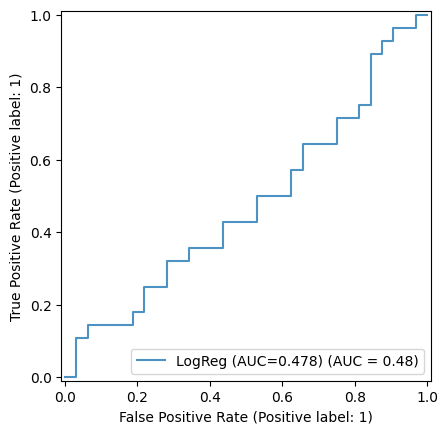

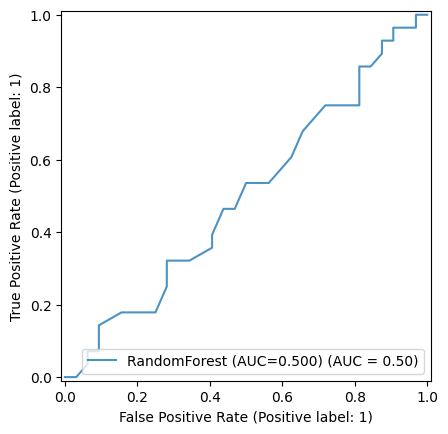

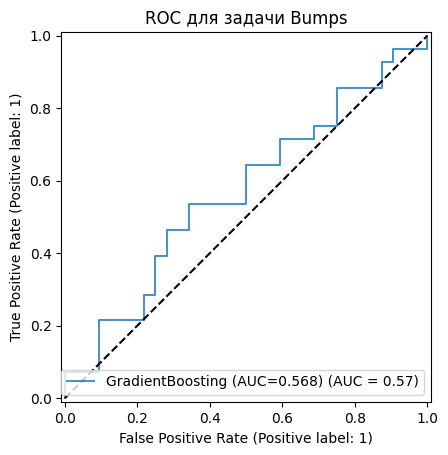

In [31]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
# Мишень Bumps
y_bumps = df["Bumps"].values
X_bumps = df.drop(columns=["Bumps"]).values
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bumps, y_bumps, test_size=0.3, random_state=42, stratify=y_bumps)
models_bumps = {
    "LogReg": make_pipeline(StandardScaler(), LogisticRegression(max_iter=200)),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
}
plt.figure(figsize=(8,6))
for name, model in models_bumps.items():
    model.fit(X_train_b, y_train_b)
    proba = model.predict_proba(X_test_b)[:,1]
    auc = roc_auc_score(y_test_b, proba)
    RocCurveDisplay.from_predictions(y_test_b, proba, name=f"{name} (AUC={auc:.3f})", alpha=0.8)
plt.plot([0,1],[0,1],"k--")
plt.title("ROC для задачи Bumps")
plt.show()


In [32]:
# Подбор параметров для лучшего RF
param_grid = ParameterGrid({"n_estimators": [100, 200], "max_depth": [None, 10, 20]})
best = None
for params in param_grid:
    rf = RandomForestClassifier(**params, random_state=42)
    rf.fit(X_train_b, y_train_b)
    proba = rf.predict_proba(X_test_b)[:,1]
    auc = roc_auc_score(y_test_b, proba)
    if best is None or auc > best[0]:
        best = (auc, params)
    print(params, "AUC=", round(auc,3))
print("Лучшие параметры для RF:", best)
best_rf = RandomForestClassifier(**best[1], random_state=42).fit(X_train_b, y_train_b)
print("Test accuracy лучшего RF:", accuracy_score(y_test_b, best_rf.predict(X_test_b)))


{'max_depth': None, 'n_estimators': 100} AUC= 0.521
{'max_depth': None, 'n_estimators': 200} AUC= 0.5
{'max_depth': 10, 'n_estimators': 100} AUC= 0.501


{'max_depth': 10, 'n_estimators': 200} AUC= 0.493
{'max_depth': 20, 'n_estimators': 100} AUC= 0.521
{'max_depth': 20, 'n_estimators': 200} AUC= 0.5
Лучшие параметры для RF: (0.5212053571428572, {'max_depth': None, 'n_estimators': 100})


Test accuracy лучшего RF: 0.48333333333333334
